<a href="https://colab.research.google.com/github/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/SentimentTesting%20on%20USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quant Machine Learning Research on USD (LSTM to Make Trading Decisions) RevB

## 1 Objective and Overview

A supervised learning was done to make trading decisions (No-Buy or Buy) for USD using USD's past price and MarketRisk TRMI.

The supervised model used was LSTM.  


## 1.1 Splitting Train-Validate-Test Set

1. Train from 2017-06-01 till 2018-05-31 (lBlue)
2. Validate from 2018-06-01 till 2018-07-31 (Red)
3. Test from 2018-01-01 till 2018-12-08 (Green)



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


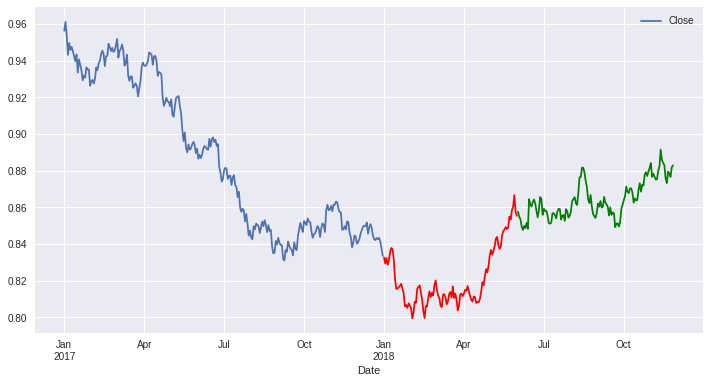

In [220]:
ax = tradeTable[:TRAIN_END].plot(y=['Close'], figsize=(12,6), grid=True)
tradeTable.Close[VALIDATE_START:VALIDATE_END].plot(ax=ax, color='r')
tradeTable.Close[TEST_START:].plot(ax=ax, color='g')

![alt text](https://github.com/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/train-validate-test.JPG?raw=1)

## 1.2 Experiments

2 experiments were done for comparison.

**Experiment 1**

Binary Prediction (True or False) was done with Binary Log Loss to predict Buy or Not-Buy trading decisions. Trading decisions were manually labelled 0(No-Buy) or 1(Buy) at each day based on whether the price of the stock will rise at the next closing price.

**Experiment 2**

Next day real returns (continuous returns value) were predicted with Mean Square Error to make Buy-or Not-Buy trading decisions.

## 1.3 Feature Engineering

![alt text](https://github.com/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/USDprice.png?raw=1)

USD price was overlayed with various TRMIs moving averages and the 30-days MarketRisk moving average seems to co-related well with the price visually. As such, the following was feature-enginnered as the input to the LSTM model for all the experiments:

1. MarketRisk
2. 7-day MarketRisk moving-average
3. 30-day MarketRisk moving-average
4. R1 (Closing Price t - Closing Price t-1)
5. R7 (Closing Price t - Closing Price t-7)

## 1.4 Evaluation Metrics

The evaluation metrics are:
1. F1 score
2. Accuracy
3. Profit and Loss

## 2 Evaluation

The results are at the end of the report.

## 2.1 Evaluation of Experiment 1 and 2

**Experiment 1**

After multiple tries, the results show that it is not able to produce result most of the time as depicted at the end of the report. Not producing result would mean that the machine did not learn much at all and predicts all Buy or Not-Buy results. As such, it could be concluded that under this report's setting, the Binary Log Loss function could not optimise the model.

**Experiment 2**

After multiple tries, the results show that it is able to produce results most of the time as shown at the end of the report, with a Mean Square Error (MSE) of 0.00001 in prediction. MSE of 0.00001 means a Root MSE of 0.0031 which means that the average returns prediction is 0.0031 off. The directions of prediction are often not right too, resulting in low F1 score. However, It can be concluded that under this report's setting, Mean Square Error function is able to optimise the model fairly well.

##  3 Codes

In [2]:
from google.colab import files
uploaded = files.upload()

Saving USDprices.csv to USDprices.csv
Saving USDSentiment.csv to USDSentiment.csv


In [3]:
!ls

sample_data  USDprices.csv  USDSentiment.csv


In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.layers import Input, LSTM, RepeatVector, Lambda, Dense, Flatten, Permute, merge, multiply
from keras.models import Model
from keras import backend as K
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score as areauc
import tensorflow as tf

## 3.1 Data Preparation

In [74]:
##Read in Price data, use date as index
Prices = pd.read_csv("USDprices.csv")
Prices.head()
Prices['Date'].dtype
Prices['Date'] = pd.to_datetime(Prices['Date'], format='%Y-%m-%d')
Prices.head()
Prices.index = Prices['Date']
# print(Prices.head())

#Reading in Sentiment Data and selecting News-only-MarketRisk Sentiment
Sent = pd.read_csv("USDSentiment.csv")
Sent = Sent[Sent.dataType=='News'][['Date', 'marketRisk']].fillna(method = "ffill")
# Sent.head()
Sent['Date'] = pd.to_datetime(Sent['Date'], format='%Y-%m-%d')
Sent.index = Sent['Date']
# print(Sent.head())

#Combining Price table and Sentiment Table
Ana = Prices.merge(Sent, left_index= True, right_index=True, how='inner')
Ana.head()
Ana.columns
Ana = Ana.drop(columns=['Unnamed: 0', 'Volume', 'Asset', 'Date_x', 'Date_y', 'Open', 'High', 'Low', 'UnadjClose'])
Ana.head()

# calculating r, %tage change of closing price over previous time step
Ana['returns'] = (Ana['Close']- Ana['Close'].shift(1))/Ana['Close'].shift(1)
Ana.head()

# calculating target price
Ana['Target'] = Ana["Close"].diff(1).shift(-1)
Ana.head()

# calculating %change
Ana['Change'] = Ana["returns"].shift(-1)
Ana.head()


## Label each time step False(no-buy) or True(buy) based on whether the price will rise at the next closing price
timestep = 7
labels = []
for i in range(0, Ana.shape[0]):
  if(i+timestep< Ana.shape[0]):
    aheadGain = [Ana["returns"][i+j] for j in range(1,timestep+1)]
    labels+= [np.sum(aheadGain)> 0]

print(len(labels))

# Price Table with Labels as Signal
Ana = Ana.iloc[:-timestep,:].copy()
Ana.head()
Ana['Signal'] = labels
Ana.head()

#Feature Engineering
Ana["Close30"] =  Ana["Close"].rolling(30).mean()
Ana["Close100"] =  Ana["Close"].rolling(100).mean()
Ana["r1"] =  Ana["Close"].diff(1)
Ana["r2"] =  Ana["Close"].diff(7)
Ana["marketrisk_avg30"] = Ana["marketRisk"].rolling(30).mean()
Ana["marketrisk_avg90"] = Ana["marketRisk"].rolling(90).mean()

#Drop NA
Ana = Ana.dropna(0)
Ana.head()

5442


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90
Date,,,,,,,,,,,,
1998-05-21,0.894694,0.017921,-0.005816,-0.001439,-0.001608,True,0.905687,0.916241,-0.005234,-0.007833,0.030184,0.034995
1998-05-22,0.893256,0.054887,-0.001608,0.004813,0.005388,True,0.904816,0.916045,-0.001439,-0.011721,0.030500,0.035283
1998-05-25,0.898069,0.072076,0.005388,0.001373,0.001529,True,0.904089,0.915792,0.004813,-0.005518,0.031202,0.035543
1998-05-26,0.899442,0.120229,0.001529,0.006027,0.006700,False,0.903746,0.915530,0.001373,-0.007587,0.034618,0.036311
1998-05-27,0.905469,0.057863,0.006700,-0.001718,-0.001898,False,0.903617,0.915352,0.006027,-0.001643,0.036330,0.036533


In [75]:
#Define function to convert dataframe to training, validating and testing examples
def series_to_supervised(df, n_in=1, n_out=1):
	n_vars = 1 if type(df) is list else df.shape[1]
  
  
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, -1, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	return agg

#Features Selection
Set =  Ana[['Close', 'Close100', 'marketrisk_avg90', 'marketrisk_avg30']]
# Set =  Ana[['r1', 'r2']]
FEATURES_SHAPE =  Set.shape[1]
print(FEATURES_SHAPE)

#Forming examples
SEQ_LEN = 5
Set =  series_to_supervised(Set, SEQ_LEN-1, 0)
Set[["Change", "Signal"]] = Ana[["Change", "Signal"]]
Set = Set.dropna()
print(Set.shape)
Set.head()

4
(5339, 22)


,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,False
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,True


In [76]:
#Remove bad training and validating examples
SetAdjusted = Set.copy()
# SetAdjusted = Set.loc[(Set.Change< -0.0015)| (Set.Change> 0.003)]
SetAdjusted.head()

,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,False
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,True


## 3.2 Train-Validate-Test Split

In [77]:
#Set x and y variables
FIRSTTRAINVAR = SetAdjusted.columns[0]
print(FIRSTTRAINVAR)
LASTTRAINVARIABLE = SetAdjusted.columns[-3]
print(LASTTRAINVARIABLE)
YVAR= "Signal"

#Split train and test set at TRAIN_DATE_END and TEST_DATE_START
TRAIN_START = "2017-01-01"
TRAIN_END = "2017-12-31"
VALIDATE_START = "2018-01-01"
VALIDATE_END = "2018-05-31"
TEST_START = "2018-06-01"
TEST_END = "2018-12-08"

#Specify LSTM input shape
X_SHAPE1 = 5
X_SHAPE2 = FEATURES_SHAPE

#train_x
train_x = SetAdjusted.loc[TRAIN_START:TRAIN_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
# print(train_x.head())
scaler = MinMaxScaler(feature_range=(0, 1))
train_x = scaler.fit_transform(train_x)
print(train_x.shape)
#reshape train_x for RNN input
train_x = train_x.reshape(train_x.shape[0], X_SHAPE1, X_SHAPE2)
print(train_x.shape)

#train_y
train_y = SetAdjusted.loc[TRAIN_START:TRAIN_END, YVAR]
train_y = train_y.values.reshape((train_y.shape[0], 1))
yscaler = MinMaxScaler(feature_range=(0, 1))
# train_y = yscaler.fit_transform(train_y)
print(train_y.shape)

#validate_x
validate_x = SetAdjusted.loc[VALIDATE_START:VALIDATE_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
validate_x = scaler.transform(validate_x)
#reshape test_x for RNN input
validate_x = validate_x.reshape(validate_x.shape[0], X_SHAPE1, X_SHAPE2)
print(validate_x.shape)

#validate_y
validate_y = SetAdjusted.loc[VALIDATE_START:VALIDATE_END, YVAR]
validate_y = validate_y.values.reshape((validate_y.shape[0], 1))
# validate_y = yscaler.transform(validate_y)
print(validate_y.shape)

#test_x
test_x = Set.loc[TRAIN_START:TEST_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
test_x = scaler.transform(test_x)
#reshape test_x for RNN input
test_x = test_x.reshape(test_x.shape[0], X_SHAPE1, X_SHAPE2)
print(test_x.shape)

#test_y
test_y = Set.loc[TRAIN_START:TEST_END, YVAR]
test_y = test_y.values.reshape((test_y.shape[0], 1))
# test_y = yscaler.transform(test_y)

print(test_y.shape)


TESTEND = test_x.shape[0]
TESTSTART = train_x.shape[0] + validate_x.shape[0]
VALIDATESTART = train_x.shape[0]

Close(t-4)
marketrisk_avg30(t-0)
(260, 20)
(260, 5, 4)
(260, 1)
(108, 5, 4)
(108, 1)
(489, 5, 4)
(489, 1)


## 3.3 Training

In [0]:
## Specifying Batch Size
n_batch = 2

In [0]:
## Only to use when removing model 
!rm best.h5

In [90]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def areaUnderCurve(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
  
#Check train_y statistic
trainStats = np.unique(train_y, return_counts=True)
print(trainStats)

#Set Classweight
if trainStats[1][0] > trainStats[1][1]: 
  classweight = {0:1, 1:trainStats[1][0]/trainStats[1][1]}
else:
  classweight = {0:trainStats[1][1]/trainStats[1][0], 1:1}
  
print(classweight)

units = 20
inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
secondary = LSTM(units, return_sequences=True)(inputs)
activations = LSTM(units, return_sequences=True)(secondary)
# out = Dense(1, activation='sigmoid')(activations)


attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)


sent_representation = multiply([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

probabilities = Dense(1, activation='sigmoid')(sent_representation)


model = Model(inputs=inputs, outputs=probabilities)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=["binary_accuracy"])


# # Design LSTM Model
# model = Sequential()
# model.add(LSTM(20, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True, recurrent_dropout=0.0))
# model.add(LSTM(20, return_sequences=True, recurrent_dropout=0.0))

# # model.add(LSTM(20, batch_input_shape=(n_batch, train_x.shape[1], train_x.shape[2]),return_sequences=True, recurrent_dropout=0.0, stateful = True))
# # model.add(LSTM(20,return_sequences=False, recurrent_dropout=0.0, stateful = True))

# # model.add(Dense(20))
# # model.add(Activation('relu'))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['matthews_correlation'])
# # model.compile(loss='mean_squared_error', optimizer='adam')

# Checkpoint
checkpoint = ModelCheckpoint("best.h5", monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
callbacks_list = [checkpoint]

# Fit model
if os.path.isfile("best.h5"):
  model.load_weights("best.h5")

history = model.fit(train_x, train_y, epochs=150,  batch_size=n_batch, callbacks=[checkpoint, early],
                    validation_data=(validate_x, validate_y), shuffle=False, 
                      class_weight= classweight
                      )


# for i in range(30):
#   model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(validate_x, validate_y), callbacks=[checkpoint, early] 
# #             ,class_weight= {0:1, 1:1}
#            )
#   model.reset_states()

(array([False,  True]), array([156, 104]))
{0: 1, 1: 1.5}
Train on 260 samples, validate on 108 samples
Epoch 1/150
260/260 [==============================] - 7s 26ms/step - loss: 0.8346 - binary_accuracy: 0.5231 - val_loss: 0.6933 - val_binary_accuracy: 0.4352

Epoch 00001: val_binary_accuracy improved from -inf to 0.43519, saving model to best.h5
Epoch 2/150
260/260 [==============================] - 1s 4ms/step - loss: 0.8344 - binary_accuracy: 0.5769 - val_loss: 0.6918 - val_binary_accuracy: 0.6481

Epoch 00002: val_binary_accuracy improved from 0.43519 to 0.64815, saving model to best.h5
Epoch 3/150
260/260 [==============================] - 1s 4ms/step - loss: 0.8347 - binary_accuracy: 0.5731 - val_loss: 0.6900 - val_binary_accuracy: 0.6481

Epoch 00003: val_binary_accuracy did not improve from 0.64815
Epoch 4/150
260/260 [==============================] - 1s 4ms/step - loss: 0.8352 - binary_accuracy: 0.5731 - val_loss: 0.6881 - val_binary_accuracy: 0.6852

Epoch 00004: val_binar

<function matplotlib.pyplot.show>

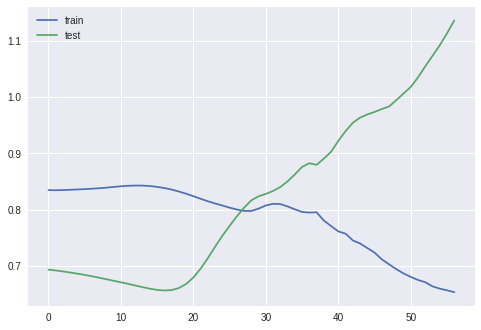

In [91]:
# Plot Learning Curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show

## 3.4  Predicting

In [92]:
# Make predictions, yhat, on test set
if os.path.isfile("best.h5"):
  model.load_weights("best.h5")
yhat = model.predict(test_x, batch_size=n_batch)
# yhat = yscaler.inverse_transform(yhat)

print(yhat.shape)

## Reading yhat as predictSignal
tradeTable= Ana.loc[TRAIN_START:,:].copy()
tradeTable["predictSignal"] = yhat>0.5
# tradeTable["predictPrice"] = yhat
# tradeTable["predictSignal"]= tradeTable["predictPrice"]>0
tradeTable.head()

#Changing Signals to Weights
tradeTable['predictedweight'] = np.where(tradeTable['predictSignal'] == True, 1, -1)
tradeTable['labelledweight'] = np.where(tradeTable['Signal'] == True, 1, -1)
tradeTable.head()

# calculating r, %tage change of closing price over previous time step
tradeTable['r'] = (tradeTable['Close']- tradeTable['Close'].shift(1))/tradeTable['Close'].shift(1)
tradeTable.head()

# calculating predicted and labelled trade returns over each time step
tradeTable['predictedreturns'] = tradeTable['r']*tradeTable['predictedweight'].shift(1)
tradeTable['labelledreturns'] = tradeTable['r']*tradeTable['labelledweight'].shift(1)

tradeTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
TrainTable =  tradeTable.loc[TRAIN_START:TRAIN_END,:].copy()
TrainTable["labelledPNL"] =  (1+TrainTable['labelledreturns']).cumprod()
TrainTable["PNL"] = (1+TrainTable['predictedreturns']).cumprod()
TrainTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
ValTable =  tradeTable.loc[VALIDATE_START:VALIDATE_END,:].copy()
ValTable["labelledPNL"] =  (1+ValTable['labelledreturns']).cumprod()
ValTable["PNL"] = (1+ValTable['predictedreturns']).cumprod()
ValTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
PNLTable =  tradeTable.loc[TEST_START:"2018-12-08",:].copy()
PNLTable["labelledPNL"] =  (1+PNLTable['labelledreturns']).cumprod()
PNLTable["PNL"] = (1+PNLTable['predictedreturns']).cumprod()
PNLTable.head()

(489, 1)


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90,predictSignal,predictedweight,labelledweight,r,predictedreturns,labelledreturns,labelledPNL,PNL
Date,,,,,,,,,,,,,,,,,,,,
2018-06-01,0.857633,0.069993,0.002573,-0.002786,-0.003248,False,0.842374,0.820425,0.002201,0.002640,0.064267,0.047742,True,1,-1,0.002573,0.002573,-0.002573,0.997427,1.002573
2018-06-04,0.854847,0.041861,-0.003248,-0.001386,-0.001622,False,0.843562,0.820766,-0.002786,0.001532,0.062290,0.047795,True,1,-1,-0.003248,-0.003248,0.003248,1.000667,0.999316
2018-06-05,0.853461,0.046914,-0.001622,-0.004060,-0.004757,True,0.844756,0.821145,-0.001386,-0.004908,0.060955,0.047848,True,1,1,-0.001622,-0.001622,0.001622,1.002290,0.997696
2018-06-06,0.849401,0.038912,-0.004757,-0.001728,-0.002034,True,0.845654,0.821482,-0.004060,-0.011036,0.060158,0.048034,True,1,1,-0.004757,-0.004757,-0.004757,0.997522,0.992950
2018-06-07,0.847673,0.030235,-0.002034,0.002233,0.002635,True,0.846364,0.821787,-0.001728,-0.019028,0.059088,0.047821,True,1,1,-0.002034,-0.002034,-0.002034,0.995493,0.990930


## 3.5 Results

## 3.5.1 Experiment 1 Predict Up or Down with Binary Classification Loss function

In [0]:
# define confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize= (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plotConfusion(start, end):
  real = tradeTable["labelledweight"]
  pred = tradeTable["predictedweight"]
  cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
  accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
  f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
  auc = np.around(areauc(real[start:end], pred[start:end]), 2)
  prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
  recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
  mcc =  np.around(matthews_corrcoef(real[start:end], pred[start:end]), 2)
  # np.set_printoptions(precision=2)


  plot_confusion_matrix(cnf_matrix, classes=['no-buy', 'buy'],
                        title='Accuracy: ' +str(accuracy)
                        + ', AUC:' + str(auc)
                        + ', F1 Score:' + str(f1)
#                         + ', Precison:' + str(prec)
#                         + ', Recall:' + str(recall)
                        + ', MCC:' + str(mcc))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Confusion matrix, without normalization
[[156   0]
 [104   0]]
Confusion matrix, without normalization
[[15 32]
 [ 2 59]]
Confusion matrix, without normalization
[[51  4]
 [57  9]]


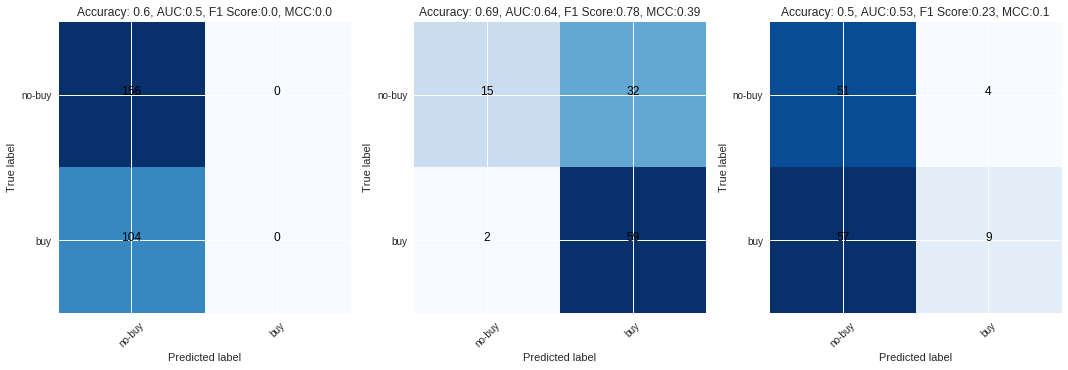

In [94]:
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)

plotConfusion(TRAIN_START, TRAIN_END)

plt.subplot(132)

plotConfusion(VALIDATE_START, VALIDATE_END)

plt.subplot(133)

plotConfusion(TEST_START, TEST_END)

plt.show()

Confusion matrix, without normalization
[[87 53]
 [64 56]]
Confusion matrix, without normalization
[[17 33]
 [15 43]]
Confusion matrix, without normalization
[[23 41]
 [31 32]]


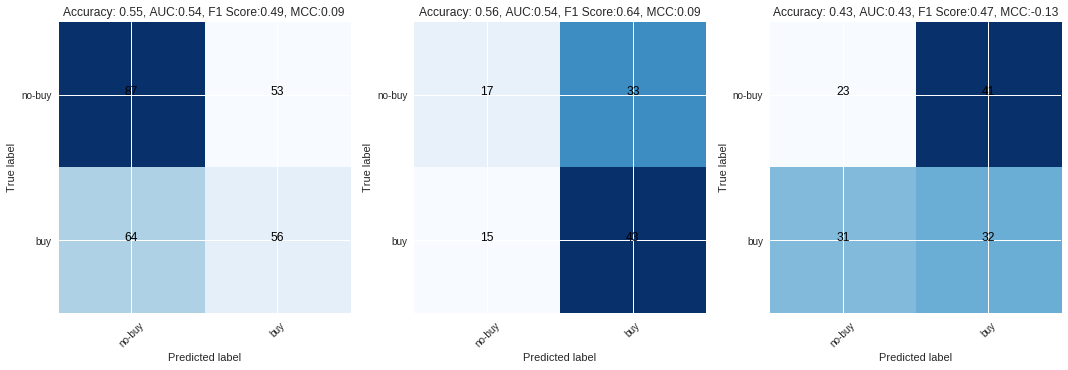

In [38]:
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)

plotConfusion(TRAIN_START, TRAIN_END)

plt.subplot(132)

plotConfusion(VALIDATE_START, VALIDATE_END)

plt.subplot(133)

plotConfusion(TEST_START, TEST_END)

plt.show()

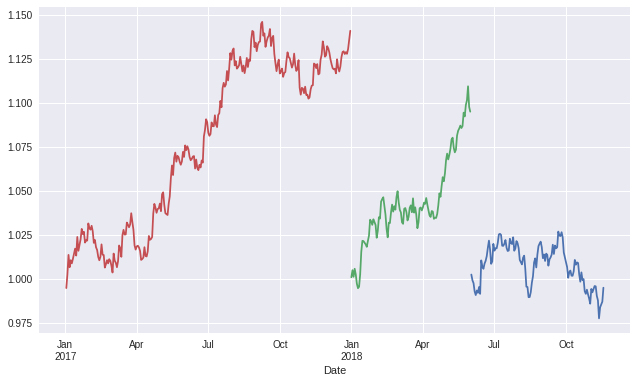

In [95]:
f = plt.figure(figsize=(36,6))
ax = f.add_subplot(131)

# PNL Plot for the Test Period
PNLTable["PNL"].plot()

# PNL Plot for the Test Period
ValTable["PNL"].plot()

# PNL Plot for the Test Period
TrainTable["PNL"].plot()

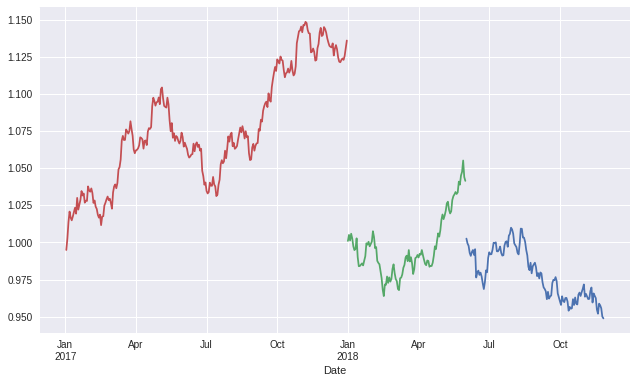

In [39]:
f = plt.figure(figsize=(36,6))
ax = f.add_subplot(131)

# PNL Plot for the Test Period
PNLTable["PNL"].plot()

# PNL Plot for the Test Period
ValTable["PNL"].plot()

# PNL Plot for the Test Period
TrainTable["PNL"].plot()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


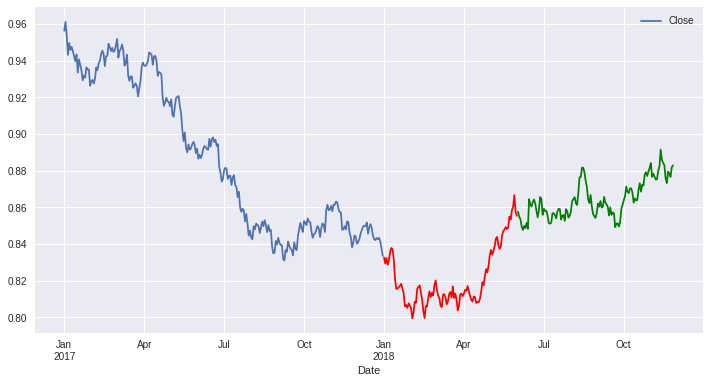

In [221]:
ax = tradeTable[:TRAIN_END].plot(y=['Close'], figsize=(12,6), grid=True)
tradeTable.Close[VALIDATE_START:VALIDATE_END].plot(ax=ax, color='r')
tradeTable.Close[TEST_START:].plot(ax=ax, color='g')

## 3.5.2 Experiment 2 Predict real return with Mean Square Error

Confusion matrix, without normalization
[[134   6]
 [115   5]]


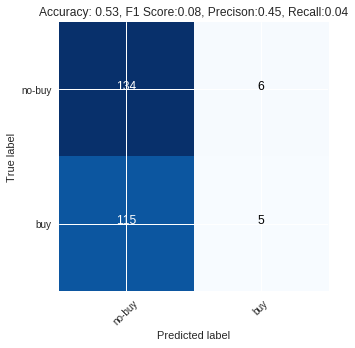

In [0]:
# Confusion Matrix for the Train Period 
real = tradeTable["labelledweight"]
pred = tradeTable["predictedweight"]

start = 0
end = VALIDATESTART
cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
np.set_printoptions(precision=2)
plt.figure(figsize= (5,5))
plot_confusion_matrix(cnf_matrix, classes=['no-buy', 'buy'],
                      title='Accuracy: ' +str(accuracy)
                      + ', F1 Score:' + str(f1)
                      + ', Precison:' + str(prec)
                      + ', Recall:' + str(recall))
plt.show()

Confusion matrix, without normalization
[[33 17]
 [39 19]]


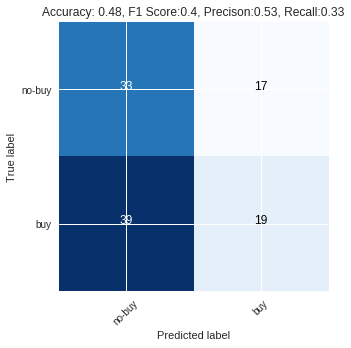

In [0]:
# Confusion Matrix for the Validate Period 
real = tradeTable["labelledweight"]
pred = tradeTable["predictedweight"]

start = VALIDATESTART
end = TESTSTART
cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
np.set_printoptions(precision=2)
plt.figure(figsize= (5,5))
plot_confusion_matrix(cnf_matrix, classes=['no-buy', 'buy'],
                      title='Accuracy: ' +str(accuracy)
                      + ', F1 Score:' + str(f1)
                      + ', Precison:' + str(prec)
                      + ', Recall:' + str(recall))
plt.show()

Confusion matrix, without normalization
[[55  9]
 [57  6]]


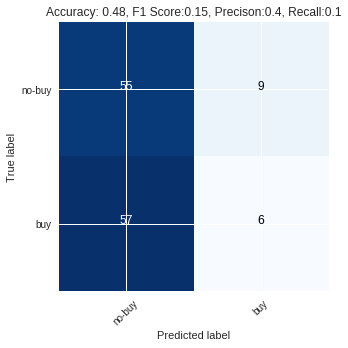

In [0]:
# Confusion Matrix for the Test Period 
real = tradeTable["labelledweight"]
pred = tradeTable["predictedweight"]

start = TESTSTART
# end = 
cnf_matrix = confusion_matrix(real[start:], pred[start:])
accuracy = np.around(accuracy_score(real[start:], pred[start:]),2)
f1= np.around(f1_score(real[start:], pred[start:], average='binary'), 2)
prec = np.around(precision_score(real[start:], pred[start:], average='binary'), 2)
recall = np.around(recall_score(real[start:], pred[start:], average='binary'), 2)
np.set_printoptions(precision=2)
plt.figure(figsize= (5,5))
plot_confusion_matrix(cnf_matrix, classes=['no-buy', 'buy'],
                      title='Accuracy: ' +str(accuracy)
                      + ', F1 Score:' + str(f1)
                      + ', Precison:' + str(prec)
                      + ', Recall:' + str(recall))
plt.show()

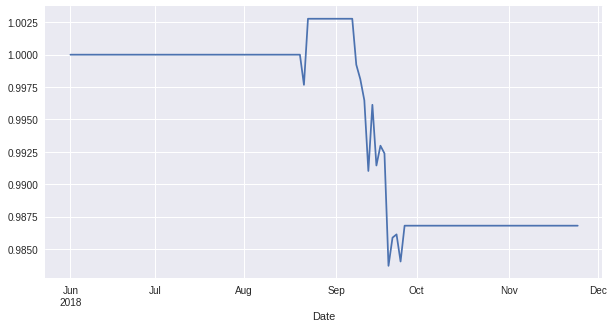

In [0]:
# PNL Plot for the Test Period
PNLTable["PNL"].plot(figsize=(10,5))

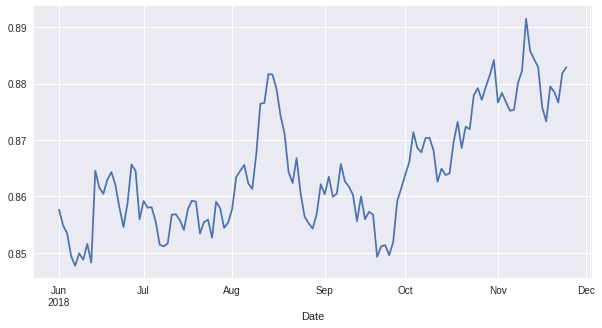

In [0]:
# Price Trend for the Test Period
tradeTable["Close"]["2018-06-01":"2018-12-08"].plot(figsize=(10,5))